In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unicodedata import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
def accent_remover(x):
    try:
        float(x)
        return x
    except:
        return normalize('NFKD',x).encode('ASCII', 'ignore').decode('ASCII')

In [3]:
dataset_2017 = pd.read_csv('datasets/datatran2017.csv', sep= ';', encoding='ISO-8859-1').dropna().drop_duplicates()
dataset_2018 = pd.read_csv('datasets/datatran2018.csv', sep= ';', encoding='ISO-8859-1').dropna().drop_duplicates()
dataset = pd.concat([dataset_2017,dataset_2018])

dataset = dataset.transform([accent_remover])
dataset.columns = dataset.columns.droplevel(1)

In [4]:
# Pega as dados das colunas:
# data_inversa	dia_semana	horario	uf	br	km	condicao_metereologica	latitude	longitude
training_set = dataset.iloc[:, [1,2,3,4,5,6,13,25,26]].values

In [5]:
# Converte os dados de string para number
encoder = LabelEncoder()
training_set[:,0] = encoder.fit_transform(training_set[:,0])
training_set[:,1] = encoder.fit_transform(training_set[:,1])
training_set[:,2] = encoder.fit_transform(training_set[:,2])
training_set[:,3] = encoder.fit_transform(training_set[:,3])
training_set[:,4] = encoder.fit_transform(training_set[:,4])
training_set[:,5] = encoder.fit_transform(training_set[:,5])
training_set[:,6] = encoder.fit_transform(training_set[:,6])
training_set[:,7] = encoder.fit_transform(training_set[:,7])
training_set[:,8] = encoder.fit_transform(training_set[:,8])

In [6]:
# Converte os dados para uma mesma faixa de valores de 0 a 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Cria a estrutura do dados com 60 timesteps e 1 saida
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i,:])
    y_train.append(training_set_scaled[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)


In [8]:
# Inicializa a RNN
regressor = Sequential()

# Adiciona a primeira camada
regressor.add(LSTM(units = 50, return_sequences = True, input_shape=(60,9)))
regressor.add(Dropout(0.2))

# Segunda camada
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Terceira camada
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Quarta camada
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Camada de saida
regressor.add(Dense(units = 9))

# Compila
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Executa o treinamento
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)


Epoch 1/10
38/38 [==============================] - 5s 141ms/step - loss: 0.0971
Epoch 2/10
38/38 [==============================] - 4s 92ms/step - loss: 0.0668
Epoch 3/10
38/38 [==============================] - 5s 119ms/step - loss: 0.0644
Epoch 4/10
38/38 [==============================] - 6s 157ms/step - loss: 0.0634
Epoch 5/10
38/38 [==============================] - 5s 138ms/step - loss: 0.0626
Epoch 6/10
38/38 [==============================] - 5s 143ms/step - loss: 0.0611
Epoch 7/10
38/38 [==============================] - 6s 149ms/step - loss: 0.0610
Epoch 8/10
38/38 [==============================] - 7s 175ms/step - loss: 0.0604
Epoch 9/10
38/38 [==============================] - 6s 153ms/step - loss: 0.0608
Epoch 10/10
38/38 [==============================] - 6s 160ms/step - loss: 0.0601


In [9]:
# Testando os dados analisados com os de 2019
dataset_test = pd.read_csv('datasets/datatran2019.csv', sep= ';', encoding='ISO-8859-1').dropna().drop_duplicates()
dataset_test = dataset_test.transform([accent_remover])
dataset_test.columns = dataset_test.columns.droplevel(1)
real_data = dataset_test.iloc[:, [1,2,3,4,5,6,13,25,26]].values

In [10]:
encoder = LabelEncoder()
real_data[:,0] = encoder.fit_transform(real_data[:,0])
real_data[:,1] = encoder.fit_transform(real_data[:,1])
real_data[:,2] = encoder.fit_transform(real_data[:,2])
real_data[:,3] = encoder.fit_transform(real_data[:,3])
real_data[:,4] = encoder.fit_transform(real_data[:,4])
real_data[:,5] = encoder.fit_transform(real_data[:,5])
real_data[:,6] = encoder.fit_transform(real_data[:,6])
real_data[:,7] = encoder.fit_transform(real_data[:,7])
real_data[:,8] = encoder.fit_transform(real_data[:,8])

In [11]:
# Realiza a predicao dos dados
dataset_total = pd.concat((dataset, dataset_test), axis = 0)
dataset_total = dataset_total.iloc[:, [1,2,3,4,5,6,13,25,26]].values

dataset_total[:,0] = encoder.fit_transform(dataset_total[:,0])
dataset_total[:,1] = encoder.fit_transform(dataset_total[:,1])
dataset_total[:,2] = encoder.fit_transform(dataset_total[:,2])
dataset_total[:,3] = encoder.fit_transform(dataset_total[:,3])
dataset_total[:,4] = encoder.fit_transform(dataset_total[:,4])
dataset_total[:,5] = encoder.fit_transform(dataset_total[:,5])
dataset_total[:,6] = encoder.fit_transform(dataset_total[:,6])
dataset_total[:,7] = encoder.fit_transform(dataset_total[:,7])
dataset_total[:,8] = encoder.fit_transform(dataset_total[:,8])

In [12]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:,:]
inputs = sc.fit_transform(inputs)
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i,:])
X_test = np.array(X_test)
predicted_data = regressor.predict(X_test)
predicted_data = sc.inverse_transform(predicted_data)

[[0 6 72 ... 0 18271 16679]
 [0 6 72 ... 7 20133 24726]
 [0 6 36 ... 0 22677 20455]
 ...
 [153 4 1018 ... 0 28501 4254]
 [193 3 1051 ... 4 22218 28796]
 [294 6 1094 ... 0 2573 3652]]


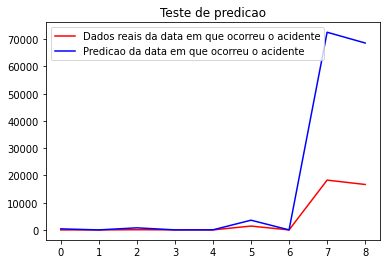

In [13]:
print(real_data)

plt.plot(real_data[0], color = 'red', label = 'Dados reais da data em que ocorreu o acidente')
plt.plot(predicted_data[0], color = 'blue', label = 'Predicao da data em que ocorreu o acidente')
plt.title('Teste de predicao')
plt.legend()
plt.show()